# Representing an Artificial Neural Network as a Cartesian Genetic Program
(a.k.a dCGPANN)

Neural networks (deep, shallow, convolutional or not) are, after all, computer programs and as such can be encoded in a chromosome and represented as a Genetic Program. A dCGPANN, coded in the class *expression_ann_double*, is exactly this: a feed forward neural network represented into a chromosome using a Cartesian Genetic Programming encoding. Derivatives with respect to weights and biases can be easily extracted, the underlying algorithm being backward automated differentiation. Unlike other dCGP expression higher order derivatives are not available (no *gduals*). 

In [1]:
# Initial import
import dcgpy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

### Instantiating and inspecting a dCGPANN

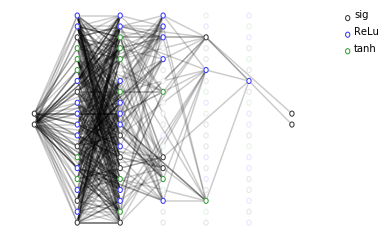

In [9]:
# A limited amount of kernels are available for dCGPANN. Notably the most common in deep learning literature are.
nonlinearities = dcgpy.kernel_set_double(["sig", "ReLu", "tanh"])
# After defining the possible nonlinearities, we instantiate the dCGPANN
dcgpann = dcgpy.expression_ann_double(inputs=2, outputs=2, rows=20, cols=5, 
                                      levels_back=2, arity=[2,20,10,10,5], kernels=nonlinearities())
# By default all weights (and biases) are set to 1 (and 0). We initialize them normally distributed
#dcgpann.randomise_weights(mean = 0., std = 0.1)
#dcgpann.randomise_biases(mean = 0., std = 0.001)

# We then visualize the network thus encoded as a cartesian program
ax = dcgpann.visualize(show_nonlinearities=True, active_connection_alpha=0.2, inactive_connection_alpha=0.0)

In [12]:
# The weights and biases can be extracted as a whole
w = dcgpann.get_weights()
b = dcgpann.get_biases()

# Or only for a specific node/input
w5_1 = dcgpann.get_weight(node_id = 5, input_id = 1)

In [13]:
# The resulting expression can, as usual be computed both on numerical values ...
x = [0.1,-0.3]
print("Value in", x, " is", dcgpann(x))

Value in [0.1, -0.3]  is [23.188787774587684, 0.9999999999969278]


In [14]:
# ... and symbolic names (this can get real messy so we show only 100 characters of the first output)
x = ["x", "y"]
print("Value in", x, " is", dcgpann(x)[0][:150])

Value in ['x', 'y']  is ReLu(b88+w88_0*sig(b64+w64_0*tanh(b24+w24_0*x+w24_1*tanh(b6+w6_0*y+w6_1*y)+w24_2*x+w24_3*ReLu(b10+w10_0*x+w10_1*y)+w24_4*ReLu(b3+w3_0*x+w3_1*y)+w24_5*


### Mutating a dCGPANN

In [15]:
# We define a single input single output dCGPANN.
dcgpann = dcgpy.expression_ann_double(inputs=1, outputs=1, rows=10, cols=5, 
                                      levels_back=2, arity=10, kernels=nonlinearities())
# By default all weights (and biases) are set to 1 (and 0). We initialize them randomly
dcgpann.randomise_weights(mean = 0., std = 0.1)



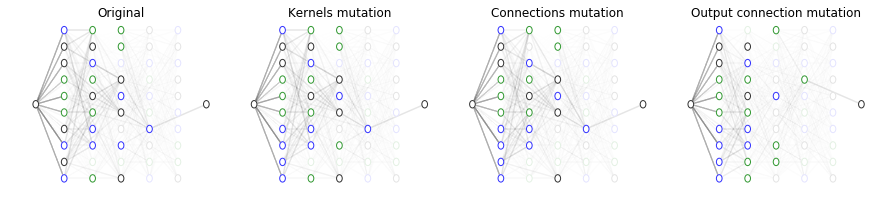

In [16]:
# As we all CGP expressions, we can now mutate producing a slightly different architecture
# Note that mutation only affect the chromosome (i.e. the ANN encoding)  not any of the weights nor biases
# We visualize the starting dCGPANN
f, ax = plt.subplots(1,4, figsize=(15,3))
ax = plt.subplot(1,4,1)
ax = dcgpann.visualize(show_nonlinearities=True, legend = False, axes = ax)
_ = ax.set_title("Original")
# mutate three function genes (these will be easily visualized)
dcgpann.mutate_active_fgene(3)
ax = plt.subplot(1,4,2)
ax = dcgpann.visualize(show_nonlinearities=True, legend = False, axes = ax)
_ = ax.set_title("Kernels mutation")
# mutate active connections (its difficult to "see" the change, except when some node become inactive or active)
dcgpann.mutate_active_cgene(30)
ax = plt.subplot(1,4,3)
ax = dcgpann.visualize(show_nonlinearities=True, legend = False, axes = ax)
_ = ax.set_title("Connections mutation")
# mutate active connections (its difficult to "see" the change, except when some node become inactive or active)
dcgpann.mutate_ogene(1)
ax = plt.subplot(1,4,4)
ax = dcgpann.visualize(show_nonlinearities=True, legend = False, axes = ax)
_ = ax.set_title("Output connection mutation")


### Training a dCGPANN

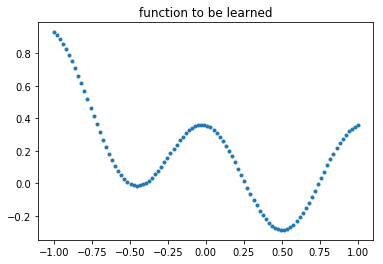

In [17]:
# We want to train the dCGPANN in a regression task. Lets create the points
points = np.linspace(-1.,1.,100)
np.random.shuffle(points)
labels = ((points-0.5)**2 + np.cos(points * 2 * np.pi)) / 3.5
points = points.reshape((100,1))
labels = labels.reshape((100,1))
plt.plot(points,labels, '.')
_ = plt.title("function to be learned")

In [18]:
# Since the output is in [-1, 1] we force the output nonliearity to be tanh
dcgpann.set_output_f(2)

print("Starting error:", dcgpann.loss(points,labels, "MSE"))
print("Net complexity (number of active nodes):", len(dcgpann.get_active_nodes()))

# This will store the learning history
res = []

Starting error: 0.12048478269722124
Net complexity (number of active nodes): 25


In [19]:
# Let's go
n_epochs = 100000

for i in tqdm(range(n_epochs)):
    dcgpann.sgd(points, labels, 0.1, 32, "MSE")
    res.append(dcgpann.loss(points,labels, "MSE"))
print("End MSE: ", dcgpann.loss(points,labels, "MSE"))


100%|██████████| 100000/100000 [00:59<00:00, 1670.72it/s]

End MSE:  4.405689220181628e-05


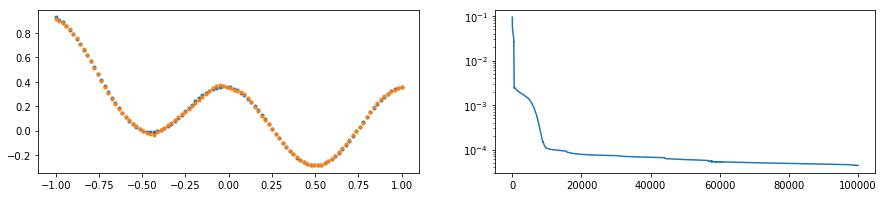

In [20]:
f, ax = plt.subplots(1,2, figsize=(15,3))
# We plot the learned function against the target
plt.subplot(1,2,1)
_ = plt.plot(points,labels, '.')
_ = plt.plot(points, [dcgpann(p) for p in points],'.')
plt.subplot(1,2,2)
# We plot the mse during learning
_ = plt.semilogy(res)
